# Import

In [1]:
# !pip install -U tensorflow==2.10.0
# !pip install -U keras==2.10.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import string
import nltk
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, Conv1D, MaxPooling1D, Activation, Flatten, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.layers import Bidirectional

#Local
# from keras.utils import to_categorical

#Kaggel
from tensorflow.keras.utils import to_categorical
import random
seed=42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# ! rm /kaggle/working/CNN_best_model.h5

# Read Dataset

In [3]:
Data = pd.read_csv("../input/malicious-phish/malicious_phish.csv")
Data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# Statistic

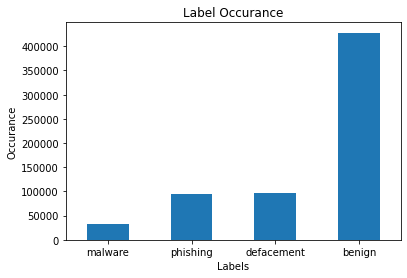

In [4]:
plt.xlabel("Labels")
plt.ylabel("Occurance")
plt.title("Label Occurance")
Data["type"].value_counts().sort_values().plot(kind = "bar",rot=360 )
plt.show()

The dataset contains 4 classes benign and other three are attacks so we can combine 3 class into 1 class

In [5]:
Data.loc[Data["type"] != "benign" , "type" ] = "attack"

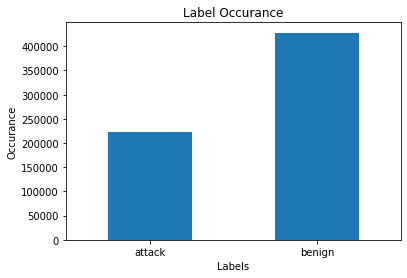

In [6]:
plt.xlabel("Labels")
plt.ylabel("Occurance")
plt.title("Label Occurance")
Data["type"].value_counts().sort_values().plot(kind = "bar",rot=360 )
plt.show()

## distripution of the URL lengths

In [7]:
d = Data["url"].apply(lambda x : len(x))

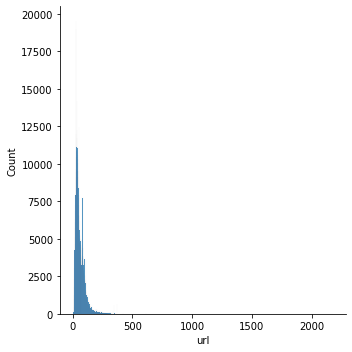

In [8]:
sns.displot(d)

# Spliting the data

## Label Encoder

In [9]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(Data.iloc[:,-1])


## spliting

In [10]:
X_train, X_test, y_train, y_test = train_test_split( Data.iloc[:,:-1], y, test_size=0.20, stratify=y,  random_state=42)

In [11]:
print(f"train length {len(X_train)}")
print(f"test length {len(X_test)}")

train length 520952
test length 130239


# Charachter Embeding

Source: http://arxiv.org/pdf/1509.01626v3.pdf

In [12]:
# Toknize the chrachters
# fit the Toknizer using the train to prevent data leakage

tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(X_train["url"].values)

In [13]:
tk.word_index

{'UNK': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'i': 6,
 '/': 7,
 'n': 8,
 'c': 9,
 's': 10,
 'r': 11,
 'm': 12,
 '.': 13,
 'l': 14,
 'p': 15,
 'd': 16,
 'h': 17,
 '-': 18,
 'w': 19,
 'u': 20,
 'b': 21,
 'g': 22,
 '1': 23,
 'f': 24,
 '0': 25,
 '2': 26,
 'y': 27,
 '=': 28,
 'k': 29,
 '3': 30,
 'v': 31,
 '8': 32,
 '%': 33,
 '5': 34,
 '4': 35,
 '9': 36,
 '_': 37,
 '7': 38,
 '6': 39,
 '&': 40,
 'x': 41,
 ':': 42,
 'j': 43,
 'z': 44,
 '?': 45,
 'q': 46,
 '+': 47,
 ';': 48,
 '\\': 49,
 "'": 50,
 '~': 51,
 '(': 52,
 ')': 53,
 'ะ': 54,
 ',': 55,
 ']': 56,
 '[': 57,
 '@': 58,
 '!': 59,
 'พ': 60,
 'ต': 61,
 '#': 62,
 '|': 63,
 ' ': 64,
 'ฝ': 65,
 'ธ': 66,
 'ฐ': 67,
 'ร': 68,
 'â': 69,
 '*': 70,
 'é': 71,
 'ผ': 72,
 'ã': 73,
 'บ': 74,
 '\x82': 75,
 '\x83': 76,
 'ฒ': 77,
 '}': 78,
 '{': 79,
 '$': 80,
 'ฑ': 81,
 'ณ': 82,
 'ฟ': 83,
 'ฮ': 84,
 'ป': 85,
 '^': 86,
 'ò': 87,
 'ô': 88,
 'è': 89,
 'ñ': 90,
 'ด': 91,
 'õ': 92,
 'น': 93,
 'ì': 94,
 'ฃ': 95,
 'æ': 96,
 'î': 97,
 'ù': 98,
 'ö': 99,
 'ê': 100,

In [14]:
chrachter_size = len(tk.word_index)
print(f"charachters length {chrachter_size}")

charachters length 273


In [21]:
train_sequences = tk.texts_to_sequences(X_train["url"].values)
test_sequences = tk.texts_to_sequences(X_test["url"].values)

In [16]:
len(train_sequences[0])

104

In [17]:
# Padding
train_data = pad_sequences(train_sequences, maxlen=500, padding='post')
test_data = pad_sequences(test_sequences, maxlen=500, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

In [19]:
print(f"train shape after padding : {train_data.shape}")
print(f"test shape after padding :  {test_data.shape}")

train shape after padding : (520952, 500)
test shape after padding :  (130239, 500)


In [20]:
import pickle

# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

## embedding_layer 

In [20]:
input_size = train_data.shape[1]
chrachter_size = len(tk.word_index)
embedding_size =  128


In [21]:
embedding_layer = Embedding(chrachter_size + 1,
                            embedding_size,
                            input_length=input_size,
                            #  weights=[embedding_weights]
                           )

## one hot encoding the labels  

In [22]:
train_classes = to_categorical(y_train)
test_classes = to_categorical(y_test)

# Shuffle

In [23]:
# Shuffle
# indices = np.arange(train_data.shape[0])
# np.random.shuffle(indices)

x_train = train_data
y_train = train_classes

x_test = test_data
y_test = test_classes

# PLot funstions

In [24]:
def plot_confusion_Matrix(y_true, y_predict, plottitle):

    #Create confusion matrix and normalizes it over predicted (columns)
    result = confusion_matrix(y_true, y_predict)
    labels = le.inverse_transform([0,1])
    df_cm = pd.DataFrame(result, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    plt.title(plottitle)
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.show()

In [35]:
def PLot_Model_Results(history,Title,Acc=True,metric="accuracy"):
    """plot Model accuracy and losse over epochs 
        Acc = True  plot Accuract garaph also
    """
    plt.figure(figsize=(10,6))

    if Acc==True:
        plt.plot(history.history[f'{metric}'])
        plt.plot(history.history[f'val_{metric}'])
        plt.title(Title)
        plt.ylabel(f'{metric}')
        plt.xlabel('epoch')
        plt.legend([f'train {metric}', f'validation {metric}'], loc='upper left')
        plt.show()
    else :
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(Title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'test loss'], loc='upper left')
        plt.show()


# Class Weights

In [26]:
total = y_train.argmax(1).shape[0]
class1 = y_train.argmax(1).sum()
class0 = total - class1

weight_for_0 = (1 / class0) * (total / 2.0)
weight_for_1 = (1 / class1) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.46
Weight for class 1: 0.76


# CNN Model

In [27]:

model = Sequential()
model.add(Input(shape=(input_size,), name='input'))
model.add(embedding_layer)

model.add(Conv1D(256, 7))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(256, 7))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3))


model.add(Conv1D(256, 7, activation='relu'))
model.add(Activation('relu'))

model.add(Conv1D(256, 7))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())

# model.add(Dense(1024))
# model.add(Dropout(0.2))

model.add(Dense(1024))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy',tf.keras.metrics.Recall()])  # Adam, categorical_crossentropy
model.summary()

2022-12-07 13:53:13.978752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:53:14.168502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:53:14.169679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          35072     
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 256)          229632    
_________________________________________________________________
activation (Activation)      (None, 494, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 164, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 158, 256)          459008    
_________________________________________________________________
activation_1 (Activation)    (None, 158, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 52, 256)           0

2022-12-07 13:53:14.176696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 13:53:14.177053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:53:14.177890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:53:14.178852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [28]:
mc = ModelCheckpoint('/kaggle/working/CNN_best_model.h5',  monitor='val_recall', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=4)

history = model.fit(x_train, y_train,
                      validation_split=0.2,
                      batch_size=32,
                      epochs=10,
                      callbacks=[es, mc],
                      class_weight=class_weight,
                      verbose=1)

2022-12-07 13:53:17.063642: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 833522000 exceeds 10% of free system memory.
2022-12-07 13:53:18.004544: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 833522000 exceeds 10% of free system memory.
2022-12-07 13:53:19.154809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-07 13:53:20.956745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13024/13024 [==============================] - 199s 15ms/step - loss: 0.1035 - accuracy: 0.9680 - recall: 0.9680 - val_loss: 0.0785 - val_accuracy: 0.9816 - val_recall: 0.9816

Epoch 00001: val_recall improved from -inf to 0.98158, saving model to /kaggle/working/CNN_best_model.h5
Epoch 2/10
13024/13024 [==============================] - 191s 15ms/step - loss: 0.0711 - accuracy: 0.9806 - recall: 0.9806 - val_loss: 0.0526 - val_accuracy: 0.9833 - val_recall: 0.9833

Epoch 00002: val_recall improved from 0.98158 to 0.98332, saving model to /kaggle/working/CNN_best_model.h5
Epoch 3/10
13024/13024 [==============================] - 191s 15ms/step - loss: 0.0616 - accuracy: 0.9826 - recall: 0.9826 - val_loss: 0.0560 - val_accuracy: 0.9840 - val_recall: 0.9840

Epoch 00003: val_recall improved from 0.98332 to 0.98395, saving model to /kaggle/working/CNN_best_model.h5
Epoch 4/10
13024/13024 [==============================] - 190s 15ms/step - loss: 0.0607 - accuracy: 0.9832 - recall: 0.9832 - 

In [29]:
model = load_model('/kaggle/working//CNN_best_model.h5')

## CNN Results

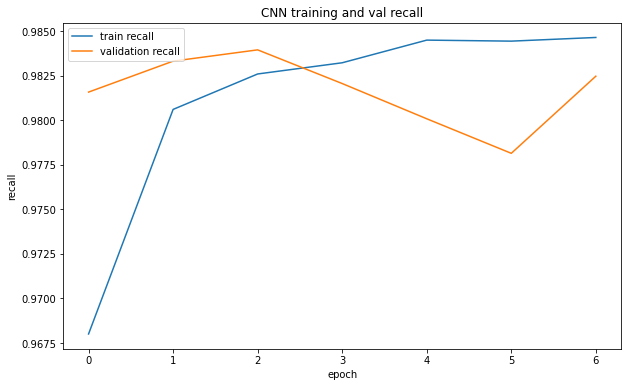

In [36]:
# PLot training and testing Accuracy
PLot_Model_Results(history , "CNN training and val recall",True,"recall")

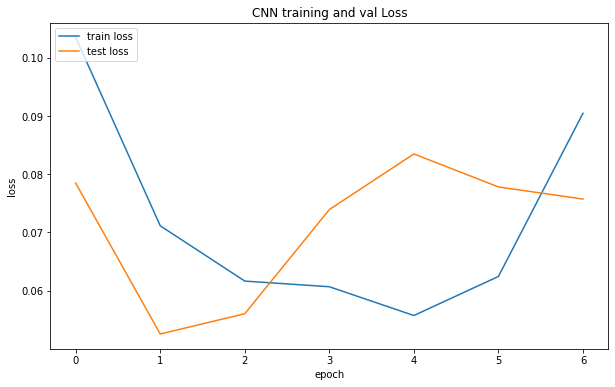

In [37]:
PLot_Model_Results(history , "CNN training and val Loss",False)

In [38]:
# classification Report
Pred_CNN = model.predict(x_test)
y_Pred_CNN = Pred_CNN.argmax(1) 
y_tets_true =y_test.argmax(1)

In [39]:
print(classification_report(y_tets_true, y_Pred_CNN, target_names= le.inverse_transform([0,1])))

              precision    recall  f1-score   support

      attack       0.98      0.97      0.98     44618
      benign       0.98      0.99      0.99     85621

    accuracy                           0.98    130239
   macro avg       0.98      0.98      0.98    130239
weighted avg       0.98      0.98      0.98    130239



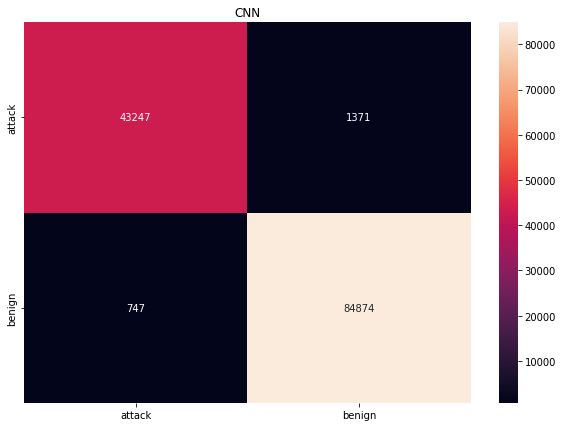

In [40]:
plot_confusion_Matrix(y_tets_true, y_Pred_CNN, "CNN")

# CNN-LSTM

In [41]:

modelCNN_LSTM = Sequential()
modelCNN_LSTM.add(Input(shape=(input_size,), name='input'))
modelCNN_LSTM.add(embedding_layer)

modelCNN_LSTM.add(Conv1D(256, 7))
modelCNN_LSTM.add(Activation('relu'))
modelCNN_LSTM.add(MaxPooling1D(pool_size=3))

modelCNN_LSTM.add(Conv1D(256, 7))
modelCNN_LSTM.add(Activation('relu'))
modelCNN_LSTM.add(MaxPooling1D(pool_size=3))


modelCNN_LSTM.add(Conv1D(256, 7, activation='relu'))
modelCNN_LSTM.add(Activation('relu'))

modelCNN_LSTM.add(Conv1D(256, 7))
modelCNN_LSTM.add(Activation('relu'))
modelCNN_LSTM.add(MaxPooling1D(pool_size=3))

modelCNN_LSTM.add(LSTM(1024))
modelCNN_LSTM.add(Dropout(0.5))

model.add(Dense(1024))
model.add(Dropout(0.2))

modelCNN_LSTM.add(Dense(2, activation='softmax'))



modelCNN_LSTM.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy',tf.keras.metrics.Recall()])  # Adam, categorical_crossentropy
modelCNN_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          35072     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 494, 256)          229632    
_________________________________________________________________
activation_4 (Activation)    (None, 494, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 164, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 158, 256)          459008    
_________________________________________________________________
activation_5 (Activation)    (None, 158, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 52, 256)          

In [42]:
Lmc = ModelCheckpoint('/kaggle/working/CNN_LSTM_best_model.h5', monitor='val_recall_1', mode='max', verbose=1, save_best_only=True)
Les = EarlyStopping(monitor='val_recall_1', mode='max', verbose=1, patience=4)

history = modelCNN_LSTM.fit(x_train, y_train,
                      validation_split=0.2,
                      batch_size=32,
                      epochs=10,
                      callbacks=[Les, Lmc],
                      class_weight=class_weight,
                      verbose=1)

2022-12-07 14:48:15.332523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 833522000 exceeds 10% of free system memory.
2022-12-07 14:48:16.258604: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 833522000 exceeds 10% of free system memory.


Epoch 1/10
13024/13024 [==============================] - 265s 20ms/step - loss: 0.1379 - accuracy: 0.9511 - recall_1: 0.9511 - val_loss: 0.0730 - val_accuracy: 0.9766 - val_recall_1: 0.9766

Epoch 00001: val_recall_1 improved from -inf to 0.97659, saving model to /kaggle/working/CNN_LSTM_best_model.h5
Epoch 2/10
13024/13024 [==============================] - 263s 20ms/step - loss: 0.0822 - accuracy: 0.9752 - recall_1: 0.9752 - val_loss: 0.0678 - val_accuracy: 0.9767 - val_recall_1: 0.9767

Epoch 00002: val_recall_1 improved from 0.97659 to 0.97668, saving model to /kaggle/working/CNN_LSTM_best_model.h5
Epoch 3/10
13024/13024 [==============================] - 263s 20ms/step - loss: 0.0863 - accuracy: 0.9735 - recall_1: 0.9735 - val_loss: 0.0665 - val_accuracy: 0.9781 - val_recall_1: 0.9781

Epoch 00003: val_recall_1 improved from 0.97668 to 0.97813, saving model to /kaggle/working/CNN_LSTM_best_model.h5
Epoch 4/10
13024/13024 [==============================] - 262s 20ms/step - loss: 0

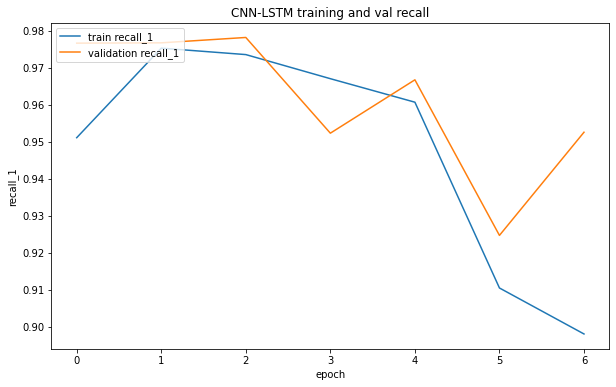

In [50]:
# PLot training and testing Accuracy
PLot_Model_Results(history , "CNN-LSTM training and val recall",True,"recall_1")

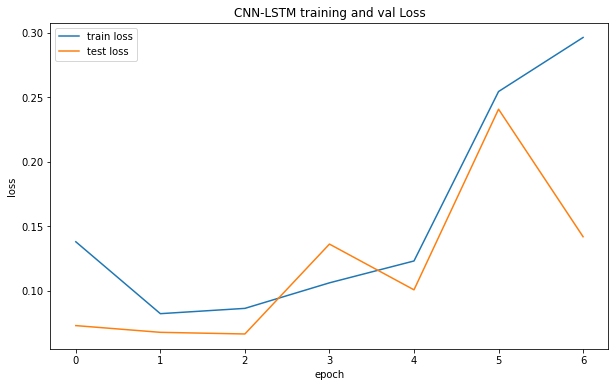

In [51]:
PLot_Model_Results(history , "CNN-LSTM training and val Loss",False)

In [43]:
modelCNN_LSTM = load_model('/kaggle/working/CNN_LSTM_best_model.h5')

In [44]:
# classification Report
Pred_CNN_LSTM = modelCNN_LSTM.predict(x_test)
y_Pred_CNN_LSTM = Pred_CNN_LSTM.argmax(1) 
y_tets_true =y_test.argmax(1)

In [45]:
print(classification_report(y_tets_true, y_Pred_CNN_LSTM, target_names= le.inverse_transform([0,1])))

              precision    recall  f1-score   support

      attack       0.98      0.96      0.97     44618
      benign       0.98      0.99      0.98     85621

    accuracy                           0.98    130239
   macro avg       0.98      0.97      0.98    130239
weighted avg       0.98      0.98      0.98    130239



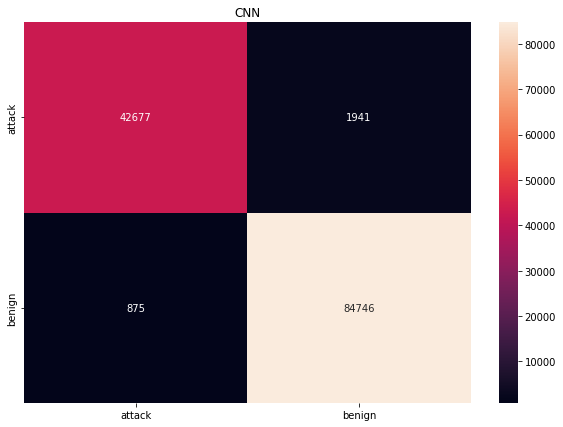

In [47]:
plot_confusion_Matrix(y_tets_true, y_Pred_CNN_LSTM, "CNN")

# CNN-BiLSTM

In [52]:

modelCNN_BILSTM = Sequential()
modelCNN_BILSTM.add(Input(shape=(input_size,), name='input'))
modelCNN_BILSTM.add(embedding_layer)

modelCNN_BILSTM.add(Conv1D(256, 7))
modelCNN_BILSTM.add(Activation('relu'))
modelCNN_BILSTM.add(MaxPooling1D(pool_size=3))

modelCNN_BILSTM.add(Conv1D(256, 7))
modelCNN_BILSTM.add(Activation('relu'))
modelCNN_BILSTM.add(MaxPooling1D(pool_size=3))


modelCNN_BILSTM.add(Conv1D(256, 7, activation='relu'))
modelCNN_BILSTM.add(Activation('relu'))

modelCNN_BILSTM.add(Conv1D(256, 7))
modelCNN_BILSTM.add(Activation('relu'))
modelCNN_BILSTM.add(MaxPooling1D(pool_size=3))

modelCNN_BILSTM.add(Bidirectional(LSTM(1024)))
modelCNN_BILSTM.add(Dropout(0.5))

modelCNN_BILSTM.add(Dense(1024))
modelCNN_BILSTM.add(Dropout(0.2))

modelCNN_BILSTM.add(Dense(2, activation='softmax'))



modelCNN_BILSTM.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy',tf.keras.metrics.Recall()])  # Adam, categorical_crossentropy
modelCNN_BILSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          35072     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 494, 256)          229632    
_________________________________________________________________
activation_8 (Activation)    (None, 494, 256)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 164, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 158, 256)          459008    
_________________________________________________________________
activation_9 (Activation)    (None, 158, 256)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 52, 256)          

In [53]:
Lmc = ModelCheckpoint('/kaggle/working/CNN_BILSTM_best_model.h5', monitor='val_recall_2', mode='max', verbose=1, save_best_only=True)
Les = EarlyStopping(monitor='val_recall_2', mode='max', verbose=1, patience=4)

history = modelCNN_BILSTM.fit(x_train, y_train,
                      validation_split=0.2,
                      batch_size=32,
                      epochs=10,
                      callbacks=[Les, Lmc],
                      class_weight=class_weight,
                      verbose=1)

2022-12-07 15:50:08.233829: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 833522000 exceeds 10% of free system memory.


Epoch 1/10
13024/13024 [==============================] - 346s 26ms/step - loss: 0.1026 - accuracy: 0.9691 - recall_2: 0.9691 - val_loss: 0.0680 - val_accuracy: 0.9805 - val_recall_2: 0.9805

Epoch 00001: val_recall_2 improved from -inf to 0.98047, saving model to /kaggle/working/CNN_BILSTM_best_model.h5
Epoch 2/10
13024/13024 [==============================] - 341s 26ms/step - loss: 0.1063 - accuracy: 0.9698 - recall_2: 0.9698 - val_loss: 0.1089 - val_accuracy: 0.9671 - val_recall_2: 0.9671

Epoch 00002: val_recall_2 did not improve from 0.98047
Epoch 3/10
13024/13024 [==============================] - 342s 26ms/step - loss: 0.1604 - accuracy: 0.9535 - recall_2: 0.9535 - val_loss: 0.1262 - val_accuracy: 0.9650 - val_recall_2: 0.9650

Epoch 00003: val_recall_2 did not improve from 0.98047
Epoch 4/10
13024/13024 [==============================] - 342s 26ms/step - loss: 0.2303 - accuracy: 0.9258 - recall_2: 0.9258 - val_loss: 0.2414 - val_accuracy: 0.9116 - val_recall_2: 0.9116

Epoch 00

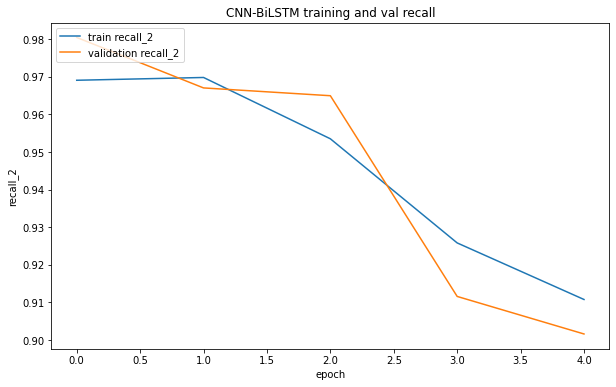

In [54]:
# PLot training and testing Accuracy
PLot_Model_Results(history , "CNN-BiLSTM training and val recall",True,"recall_2")

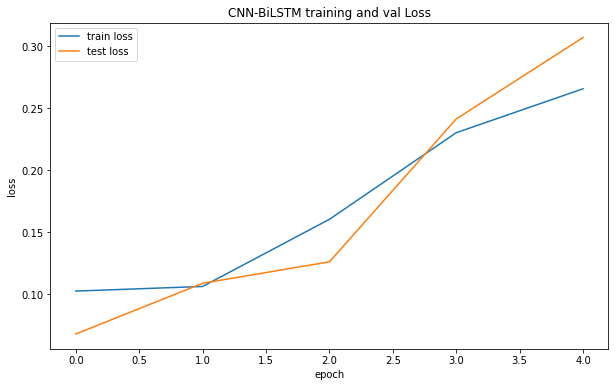

In [55]:
PLot_Model_Results(history , "CNN-BiLSTM training and val Loss",False)

In [56]:
modelCNN_BILSTM = load_model('/kaggle/working/CNN_BILSTM_best_model.h5')

In [57]:
# classification Report
Pred_CNN_BILSTM = modelCNN_BILSTM.predict(x_test)
y_Pred_CNN_BILSTM = Pred_CNN_BILSTM.argmax(1) 
y_tets_true =y_test.argmax(1)

In [58]:
print(classification_report(y_tets_true, y_Pred_CNN_BILSTM, target_names= le.inverse_transform([0,1])))

              precision    recall  f1-score   support

      attack       0.97      0.97      0.97     44618
      benign       0.99      0.98      0.98     85621

    accuracy                           0.98    130239
   macro avg       0.98      0.98      0.98    130239
weighted avg       0.98      0.98      0.98    130239



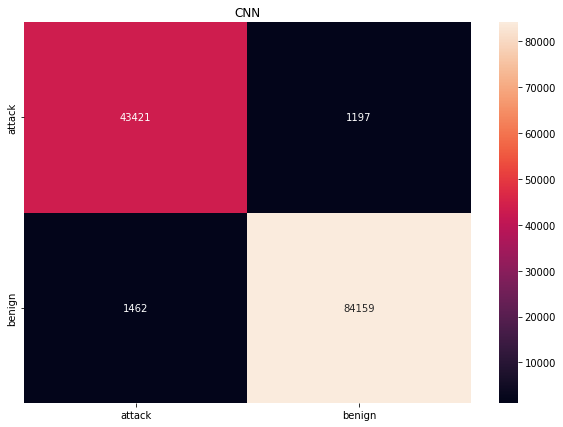

In [60]:
plot_confusion_Matrix(y_tets_true, y_Pred_CNN_BILSTM, "CNN")

In [ ]:
y_tets_true

array([1, 1, 1, ..., 1, 0, 1])

In [61]:
print("dsds")

dsds


In [72]:
True_y_Pred = le.inverse_transform(y_Pred_CNN_BILSTM)

In [73]:
True_Labels = le.inverse_transform(y_tets_true)

In [74]:
x_tests = X_test.copy().reset_index()

In [91]:
wrong = x_tests[(True_Labels !=  True_y_Pred ) & (True_Labels=="attack")]

In [93]:
Wrong_url_length  = wrong["url"].str.len()

In [94]:
Wrong_url_length

194        46
210       160
233        45
316        48
324        57
         ... 
129805     31
129834     29
129927     40
130158     23
130207     22
Name: url, Length: 1197, dtype: int64

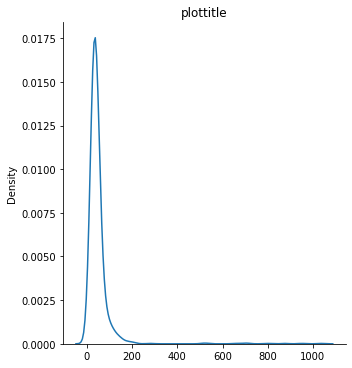

In [97]:
sns.displot( x=Wrong_url_length.values, kind="kde" ).set(title="plottitle")


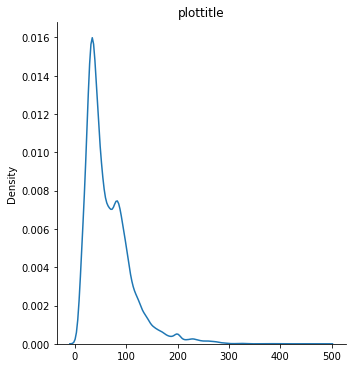

In [98]:
Right = x_tests[(True_Labels ==  True_y_Pred ) & (True_Labels=="attack")]
Right_url_length  = Right["url"].str.len()
sns.displot( x=Right_url_length.values, kind="kde" ).set(title="plottitle")


In [116]:
Wrong_domains = wrong["url"].str.split("/").str.get(0).str.split(".").str.get(-1).value_counts()[:4]

Text(0.5, 1.0, 'Most Attack Wrong Detecting Doamin')

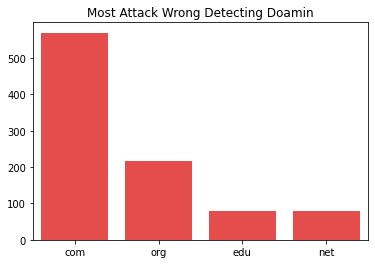

In [118]:
sns.barplot(x =Wrong_domains.index , y=Wrong_domains.values, color='r', alpha=0.8 ).set_title("Most Attack Wrong Detecting Doamin")
plt.xlabel("Doaims")
plt.ylabel("Count")